In [1]:
#       ___                       ___           ___           ___                         ___     
#      /  /\          ___        /  /\         /  /\         /  /\                       /__/\    
#     /  /:/_        /  /\      /  /:/_       /  /:/_       /  /::\                     |  |::\   
#    /  /:/ /\      /  /:/     /  /:/ /\     /  /:/ /\     /  /:/\:\    ___     ___     |  |:|:\  
#   /  /:/ /::\    /  /:/     /  /:/ /:/_   /  /:/_/::\   /  /:/  \:\  /__/\   /  /\  __|__|:|\:\ 
#  /__/:/ /:/\:\  /  /::\    /__/:/ /:/ /\ /__/:/__\/\:\ /__/:/ \__\:\ \  \:\ /  /:/ /__/::::| \:\
#  \  \:\/:/~/:/ /__/:/\:\   \  \:\/:/ /:/ \  \:\ /~~/:/ \  \:\ /  /:/  \  \:\  /:/  \  \:\~~\__\/
#   \  \::/ /:/  \__\/  \:\   \  \::/ /:/   \  \:\  /:/   \  \:\  /:/    \  \:\/:/    \  \:\      
#    \__\/ /:/        \  \:\   \  \:\/:/     \  \:\/:/     \  \:\/:/      \  \::/      \  \:\     
#      /__/:/          \__\/    \  \::/       \  \::/       \  \::/        \__\/        \  \:\    
#      \__\/                     \__\/         \__\/         \__\/                       \__\/    
#                       Made by: Hd0/Hariama | #PART3: SECURITY

# Now that we know that the capacity in our DistilBERT-model is quite large
# (ref., the entire Tao Te Ching fits in it), Let's see if we can secure our
# input, as right now, it's still quite possible to find the decimal
# representations if the analyst realizes that all floats starting with 0.1 or
# -0.1 might be potential candidates for string-decoding. So lets add an
# encryption layer around that to make it nigh impossible!

# We'll first have to load in the model like last time. I'll leave the code to
# start out with in such a way that if this is the first Jupyter notebook that
# you run in this series, it will build the clean model first (or load it if you
# already trained it before)

# Load in all the necessary libraries. Don't forget to run the requirements.txt
# file with conda to actually install all these packages. You can do this with
# conda install --file requirements.txt

# General packages for ML
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sn

# Little hacky way to present Collab-esque TQDM-loading in VSCode
import tqdm.notebook
import sys
sys.modules["tqdm.auto"] = tqdm.notebook

# A check to see if cuda is available, but really, don't try to run this code
# without a GPU, it will take forever
cuda_available = torch.cuda.is_available()

In [2]:
# Here we load the transformers and simpletransformers libraries. I like using
# simpletransformers because it's a fun abstraction layer, and most
# transformers-functionality can be emulated with it very easily. For everything
# else, we can extract functions from the OG-transformers library. The first
# time you run this cell, the DistilBERT-model will be downloaded under
# user/.cache/transfomers

# NOTE: Please learn from my mistakes. When initializing/loading a model with
# simpletransformers, the actual model chosen in the case of binary
# classification is the *ForSequenceClassification. This is what happens when
# you rely on abstraction-layers. Anyway, if you load the right
# transformer-model directly to manually adjust the weights, the correct
# training layers will be initialized downstream
from transformers import DistilBertForSequenceClassification
from simpletransformers.classification import ClassificationModel

model = ClassificationModel('distilbert','distilbert-base-uncased')
tokenizer = model.tokenizer

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# This is an artefact I'm leaving in. Here I created the requirements.txt to
# make setup for this virtualenv just a little easier

# conda list -e > requirements.txt

In [4]:
# Reading in the training/test-data, this is a remnant of my Master in Digital
# Text Analysis, where we utilized data from the OLID-competition of 2020 (I
# believe, not sure about this!)
df = pd.read_csv(r'data\olid-training-v1.0_cleaned_final.csv')

In [5]:
# We rename the columns to be in line with what the simpletransformers library
# expects
df.columns=['id','text','labels']

In [6]:
# Let's see what is in the dataframe
df.head()

,id,text,labels
0,86426,ask native americans,OFF
1,90194,home drunk oncomingfist oncomingfist,OFF
2,16820,amazon investigate chinese employee sell inter...,NOT
3,62688,piece shit volcano facewithtearsofjoy,OFF
4,43605,obama want liberal amp illegal red state,NOT


In [7]:
# Okay, so here we only call the text and labels-columns out of the dataframe,
# because the simpletransformers library can only work with these two fields
task_df = df[['text', 'labels']]
task_df.head()

,text,labels
0,ask native americans,OFF
1,home drunk oncomingfist oncomingfist,OFF
2,amazon investigate chinese employee sell inter...,NOT
3,piece shit volcano facewithtearsofjoy,OFF
4,obama want liberal amp illegal red state,NOT


In [8]:
# First split in train/test-dataframes, then into train/dev-dataframes. Note that
# we do not split into X_train and y_train, because the transformer-model predict 
# function takes both lists as one
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(task_df, test_size=0.2, shuffle=True, random_state=42, stratify=task_df['labels'])
train_df, dev_df = train_test_split(train_df, test_size=0.25, shuffle=True, random_state=42, stratify=train_df['labels'])

In [9]:
# This is a general hyperparamater-setup of mine to run this model with, it's
# something that I designed and kept on using during my Master's. I keep on
# using it because it works

# Setting up batch size, here we pick 16
train_batch_size = 16
if train_batch_size % 4 != 0:
    raise ValueError('Train_batch_size is not % 4 == 0')

# Setting up gradient accumulation size, to lower the total memory needed in my
# GPU, as I personally only got 6 GB (I'm a sparse person!)
gradient_accu_size = int(64 / train_batch_size)
print(f"Gradient accu size: {gradient_accu_size}")

# Setting up the steps per epoch and validation steps, based on the batch-size
# and the total length of the training-dataframe
steps_per_epoch = int(np.ceil(len(train_df) / float(train_batch_size)))
validation_steps = steps_per_epoch / 4 # Is just a random number to split up the validations, change to flavor
print(f"Expected steps per epoch: {steps_per_epoch}")
print(f"Necesarry validation steps per epoch: {round(validation_steps)}")

# Little function to figure out the max-length of the total amount of tokens
# based on the training-dataframe. Most transfomer-based models only take a max
# amount of 512 tokens, so if the longest sequence in the training-dataframe is
# shorter, we'll decrease this hyperparameter to not use any useless padding
# during training. Green-IT is a necessity, not an option
def max_len(tokenizer, text):
    token_lens = []

    for txt in text:
        tokens = tokenizer.encode(txt, max_length=512, truncation=True)
        token_lens.append(len(tokens))
    max_length=sorted(token_lens, reverse=True)[0]
    return max_length

# And here we setup the max_length hypeerparameter
max_length = max_len(tokenizer, train_df['text'])
print(max_length)

# So you might notice here, "hey, I thought we already initialized a model
# earlier?". And you're right, but this was only to extract the tokenizer. Here
# we run all arguments for the model to actually train it. Again, the
# hyperparameters which are static are just a personal preference (ref., again
# in the category "it-just-works"). The two labels are defined, as we only have
# two classes to classify on
model = ClassificationModel('distilbert',
                            'distilbert-base-uncased',
                            num_labels=2,
                            args={'labels_list': ["OFF", "NOT"],
                            'train_batch_size': train_batch_size, 
                            'gradient_accumulation_steps': gradient_accu_size, 
                            'learning_rate': 1e-5, 
                            'num_train_epochs': 5, 
                            'max_seq_length': max_length,
                            'overwrite_output_dir': True,
                            'gradient_checkpointing': False,
                            'use_early_stopping': True,
                            'early_stopping_delt': 0.01,
                            'early_stopping_metric': 'eval_loss',
                            'early_stopping_metric_minimize': True, 
                            'early_stopping_patience': 2,
                            'evaluate_during_training': True,
                            'evaluate_during_training_steps': validation_steps,
                            'evaluate_during_training_silent': False,
                            'evaluate_each_epoch': True,
                            # 'sliding_window': True
                            },
                            use_cuda=cuda_available)

Gradient accu size: 4
Expected steps per epoch: 493
Necesarry validation steps per epoch: 123
141


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# So this is just a little piece to speed up the process, as I've already
# trained the model locally. If you're doing this for the first time, inject the
# flag to "True". This should take around 15 to 20 minutes on a GTX 1060 6GB.
# Otherwise you're just going to take the best_model from an earlier training
# session. Be sure to have enough space, the outputs will take around 5.5 GBs op
# space!
def train_or_load(model, train=False):
    if train != False:
        _, history = model.train_model(train_df, eval_df = dev_df)
        model = ClassificationModel("distilbert", r"outputs\best_model")
        return model
    else:
        model = ClassificationModel("distilbert", r"outputs\best_model")
        return model

model = train_or_load(model)

In [11]:
# Here we check the general result of the evaluation of the model on the
# dev-dataframe. Should take around half a minute to run
result, model_outputs, wrong_predictions = model.eval_model(dev_df)

  0%|          | 0/2628 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/329 [00:00<?, ?it/s]

In [12]:
# Continuation on the evaluation results
print(f"Results of model: {result}")

Results of model: {'mcc': 0.5350964533281166, 'tp': 1514, 'tn': 579, 'fp': 301, 'fn': 234, 'auroc': 0.8452413147493238, 'auprc': 0.90468145761584, 'eval_loss': 0.45348839339514274}


In [13]:
# Here we make predictions with the model based on test-dataframe. Should again
# take around half a minute to run
predicted, probabilities = model.predict(test_df['text'].to_list())
test_df['predicted'] = predicted

  0%|          | 0/2628 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

In [14]:
# Print results of classification of hatespeech based on the cleaned OLID data.
# Originally the best model (ref., HateBERT) at the time of the contest got around 82% Macro
# F1-score, which was done by an entire research team at the University of
# Groningen. So anything above 75% is pretty fly for this solo-rider, especially
# with such a small model
print(classification_report(test_df['labels'], test_df['predicted']))

              precision    recall  f1-score   support

         NOT       0.83      0.87      0.85      1748
         OFF       0.71      0.64      0.67       880

    accuracy                           0.79      2628
   macro avg       0.77      0.75      0.76      2628
weighted avg       0.79      0.79      0.79      2628



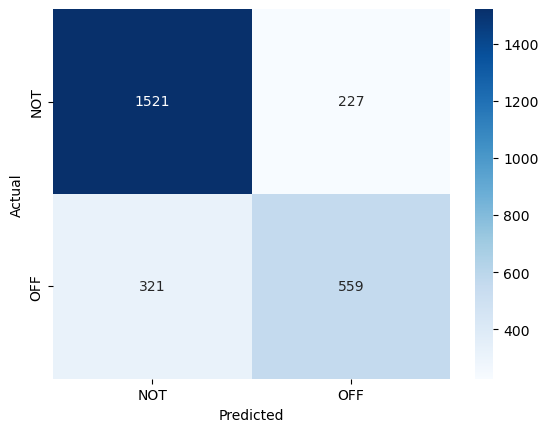

In [15]:
# Plot the confusion matrix of the unpoisoned model
confusion_matrix = pd.crosstab(test_df['labels'], test_df['predicted'], rownames=['Actual'], colnames=['Predicted']) 
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

### PART1: Running the characters in the most significant bits, encrypted
In the PART2: CAPACITY we foud out that the most stable way to include our text
to the floats of choice is by utilizing the most significant bits. Lets stick
with that, and add an encryption step so the text would come over as gibberish
without the encryption key. And this would be expected behavior, as we've seen
in PART1: POC that decoding floats of a token that don't contain
character-encodings does look like gibberish indeed

In [16]:
# This is really a re-run of PART2: CAPACITY, so that we can build on the
# multiline support. skip over the parts that don't interest you

# So now that we have our hatespeech classifier up and running, we've got to
# identify the weights which are the least likely to occur in
# training-dataframes. The reason why is because the occurence of a subword or
# word may change the weights significantly, causing "catastrophic forgetting"
# of - in this case - the targeted encoding of stego-revshell code. One hacky
# way of doing this is just going to the end of the vocab of the model. Another
# way is by manually designing and adding null-tokens, and extending the 
# tokenizer. NOTE: we'll get back to this once I get the basics running

# Anyway, now that we know that the classifier works, we'll dive a bit deeper
# in the embeddings of the actual transformer to see whats-what. We can keep the
# tokenizer we initialized earlier, because this hasn't changed
t_model = DistilBertForSequenceClassification.from_pretrained(r"outputs\best_model")

# We know that in this case, the tokenizer has a length of 30522 tokens, so
# let's see what is in the final 10
print(len(tokenizer))
print("===starting from end===")
for i in range(10):
    print(tokenizer.decode(len(tokenizer) - i))

# Okay, these seem like pretty important tokens... Let's dive a bit deeper at
# the end. Here we have a bunch of subword and full words. What we want is
# full words, as subwords are used in different token-compositions, making them
# more important for re-constructing weights, diminishing the overall
# performance of the model if we mess with them too much. Last time we didn't
# really take into account to total amount of floats that we need to hide our
# text, but this time we'll have to, based on the total amount of characters in
# the used book. Lets see how many words with unique identifiers we have
# available from a 1000 tokens in till around 15000
print("===starting from end, 1000 tokens in ===")
# Creating a horrible global just to aggrevate some people, I don't mind the
# hate ;)

def extract_uniq_tokens():
    uniq_token_list = []
    for i in range(15000):
        token = tokenizer.decode(len(tokenizer) - (i+1000))
        # Again, what we don't want are subtokens, so we filter for those
        if token.count("#") > 0:
            continue
        else:
            uniq_token_list.append(token)
    return uniq_token_list

uniq_tokens = extract_uniq_tokens()
# Hey look, "deprivation" is here again, from #PART1! :)
print(uniq_tokens[:10])
# Alright, 11557 uniq tokens is quite a lot of space. Let's figure out how many
# floats these have available by adjusting our little function above in a new
# cell, and create a list of tensors based on the uniq_tokens we found
print(len(uniq_tokens))

30522
===starting from end===

##～
##？
##：
##／
##．
##－
##，
##）
##（
===starting from end, 1000 tokens in ===
['earthly', 'florian', 'deprivation', 'chases', 'taluka', 'naia', 'stanza', 'inspecting', 'embroidery', 'adventurer']
11557


In [17]:
# In the POC we only identified the id of the word "deprivation" in the
# tokenizer of the model, and extracted the weights associated with it. But now
# we turn it up to eleven, because we're going to do this for a total of 11557
# tokens! But first I'll filter out only the floats which have a desirable
# amount of float-compositions
def uniq_tokens_tensors(tokens_list):
    tensor_dict = {}
    for token in tokens_list:
        with torch.no_grad():
            t_id = tokenizer.convert_tokens_to_ids(token)
            t_weights = t_model.distilbert.embeddings.word_embeddings.weight[t_id]
            target_lens = 0
            for weights in t_weights.detach().numpy():
                # This choice of float-legths is really just a remnant from the
                # PoC, where the choice of smaller lengths --> smaller odds of 
                # causing perturbations when loading the model back in
                if len(str(weights)) >= 9 and len(str(weights)) <= 10:
                    target_lens += 1
                else:
                    continue
            # This is really just a 'feel'
            if target_lens >= 25 and target_lens <= 75:
                tensor_dict[token] = t_weights
            else:
                continue
    return tensor_dict

uniq_tensor_dict = uniq_tokens_tensors(uniq_tokens)

# Alright, the so-called "best" float compositions (ref., really, this is just
# arbitrary, will have to figure out some better way to choose this) drops the
# total amount of suitable tensors
print(f"Length of tensor-list: {len(uniq_tensor_dict)} == length of unique tokens list: {len(uniq_tokens)}")
# And here we can see that the tensors can be called by their respective token,
# nice!
print(list(uniq_tensor_dict.items())[0])

Length of tensor-list: 10773 == length of unique tokens list: 11557
('earthly', tensor([-8.7723e-02, -2.3785e-02, -1.7166e-02, -7.7936e-02, -4.7125e-02,
        -5.6505e-02, -7.8498e-02,  5.5226e-04,  1.8042e-03, -9.1064e-03,
        -7.6041e-02, -3.5035e-02, -5.1399e-02,  2.1458e-02, -9.2859e-02,
        -7.4316e-02, -6.8419e-02, -2.0516e-02, -1.2172e-02,  7.2909e-03,
        -4.1666e-02, -1.0068e-01, -6.4713e-02, -1.2766e-02, -5.4684e-02,
        -4.0734e-03, -1.7979e-03, -9.9188e-02, -2.2400e-02, -1.2699e-01,
        -9.2369e-02, -5.1764e-03, -7.4527e-03, -4.1348e-02, -7.8576e-02,
        -7.4695e-02, -6.2167e-02, -6.3575e-02, -1.1293e-01, -1.0036e-01,
        -1.1948e-01, -8.8818e-02, -1.0739e-01, -4.6245e-02, -3.2149e-02,
        -4.0062e-02, -1.7900e-02, -1.2233e-02, -1.2044e-01,  1.4286e-02,
        -1.2682e-01, -3.2097e-02, -8.2087e-02,  4.8431e-02, -1.9295e-02,
        -9.0105e-02, -3.4545e-02, -3.5478e-02, -6.5844e-02, -6.2328e-02,
        -9.5836e-02, -9.2629e-02,  2.4035e-0

In [18]:
# Let's adjust the add_prog_flt-definition to only extract the total of
# len(float) <= 10 of all the tensors included in the uniq_tensor_list
def extract_len_count_tensors(tensor_dict):
    corr_flt_len_count = 0
    for tensor in tensor_dict.items():
        flt_list = tensor[1].detach().numpy()
        for i in flt_list:
            if (len(str(i)) <= 10):
                corr_flt_len_count += 1
    return corr_flt_len_count

print(f"Total space available for chars: {extract_len_count_tensors(uniq_tensor_dict)}")

Total space available for chars: 655491


In [19]:
# Lets use the first chapter of the Tao Te Ching again as an example multiline
# text

# To make it not too hard, no we just need to find a way to serialize the text
# into characters that can be turned back into the orginal text (ref., for this
# we limit ourselves to English, because Chinese characters would take an
# additional 3 characters to be endoced in decimal PER character)
with open("data/tao_te_ching_only_en_first.txt", 'r') as f:
    text_content = f.readlines()

# Arlight, so the text content is read in as a list, but since the new-lines are
# stored, why not just split everything apart? In the original text-format it
# will be correctly represented once writter like this as one big char-list
print(text_content)

# Bingo, and now once we join and print, the original text should be the same as
# the newly extracted one
char_list = [char for word in text_content for char in word]

# Commenting this print to limit the jupyter notebook lenght
print(char_list)

# And they look exactly the same (I checked! ;))
with open("data/tao_te_ching_only_en_first_rejoined.txt", 'w') as f:
    f.writelines(char_list)

# Finally, we can see that the current text only takes around 495 characters, so
# with the floats (NOTE: completely arbitrary btw, there are more than
# the original 15000 I tried to select) that are available to us, we should have
# more than enough space
print(f"Total length of characters on target text: {len(char_list)}")

['Tao Te Ching\n', '\n', '                                           Laozi\n', '\n', 'Shang Pian\n', '\n', '\n', 'Chapter 1\n', '\n', 'The Dao that can be stated, is not the eternal Dao;\n', '\n', 'The name that can be named is not the eternal name.\n', '\n', 'The unnamed is the origin of heaven and earth;\n', '\n', 'The named is the mother of the myriad things.\n', '\n', 'Therefore,\n', '\n', 'Constantly having no desire in order to view its commencement;\n', '\n', 'Constantly having desire in order to view its termination.\n', '\n', 'These two have the same origin, but they differ in name;\n', '\n', 'Both are called Mystery.\n', '\n', 'Mystery after Mystery, is the gate to all wonders.']
['T', 'a', 'o', ' ', 'T', 'e', ' ', 'C', 'h', 'i', 'n', 'g', '\n', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'L', 'a', 'o'

In [20]:
# I guess we'll first have to join the charlist to a text-string, because the
# Fernet-symmetric cryptography algorithm doesn't take lists. This is just to
# see if we can encrypt the char-list our method expects, and decrypt it later
def symmetric_enc_text(char_list):
    from cryptography.fernet import Fernet
    key = Fernet.generate_key()
    f = Fernet(key)

    temp_text = "".join(char_list)
    enc_text = f.encrypt(temp_text.encode('ascii'))
    # Okay, so this is the encrypted text-representation
    print(f"Encrypted text in ascii: {enc_text.decode('ascii')}")
    enc_char_list = [char for word in enc_text.decode('ascii') for char in word]
    # This is the char-list representation of the encrypted text, so this is
    # what we need to push through to our stegoml-algorithm
    print(f"Encrypted char-list of text in ascii: {enc_char_list}")
    temp_text = "".join(enc_char_list)
    new_enc_text = temp_text.encode('ascii')
    decrypt_text = f.decrypt(new_enc_text)
    print(decrypt_text)
    # And it does work, yay!
    print(f"Decrypted text in ascii:\n{decrypt_text.decode('ascii')}")

symmetric_enc_text(char_list)

Encrypted text in ascii: gAAAAABlImUPLP7-NbIo2w44xlwD96N-AbxY51zBxsP_HeTg9yzjP4iv-pXH1v7u4mXVe8uXA9n-BFeQN385RPgnuMcCnS855SMjez6pgWXg-ZvQXEEOg7-9ittGcayLqrK4tOjDMtk3lBJ4ox07_DrFrvfLI_-KD9xBNHgkqJQfOgAGIIHlTB-2MvkMdSOVCtrp4wAIBwqxuUn23sh2TTvxX6sL4G8gBKCLu-ERUoF0b81dKDWsYdpiTzpGQ97SAf5ikirYOewaoJA0_qJtTxtHEu3cjn4Z_6G2Jx2HtqILCWhDSmgTB77el4XMibInKeJvLxgeYDKc5VTLjIc7s9_sK-OKquZV8ad1gJV0DFI8IJ9YiM7lp6CqAOo_2J-o_fyFMMc7j567alhNLRdB0-tPBKzECOptoGRElA1vvWI_a2iAJU4Jz5TGPJ5SmXKM4os26SuQDZ4KQN52bMQ0MjGwb7HCyLQunEUZg3Wb4Y4Z-xYAnPhr6fEXPnsDsSWNyGtLoVnzKd3k7-PtQQigy0iSUkFRb2mFWVZAEhjWpVMKxNW8z9mOpUvj-yv2l4Y__Cbz6Htfr5FYXFOjRNT3Tx1RVAyp7SNi5RWIJCJKVNWOUBJtURuVDxx8I27Rm2ThupIh1AaGeClpve9pR9R5WQUhmGeD9Weuioh5dMyfyIYfWGNXv6GqzKDDi5Ho1rHqHGSF1eN72yIrZRy7BnvMz1CcP3JfI0_jAFHHTG06gQj412U7ZMMMcHNdmxuh9ICcL9rV9tEZlusJ0_bxmU4w4yWPpkjByxGZizA8qOVDsp2BKsoiDuEd_aQ=
Encrypted char-list of text in ascii: ['g', 'A', 'A', 'A', 'A', 'A', 'B', 'l', 'I', 'm', 'U', 'P', 'L', 'P', '7', '-', 'N', 'b', 'I', 'o', '2', 'w', '

In [21]:
# So lets now write the encryption and decryption fuctions which we will use
# before injecting our char_list in the NN-weights
def encrypt_text (char_list):
    from cryptography.fernet import Fernet
    key = Fernet.generate_key()
    f = Fernet(key)

    temp_text = "".join(char_list)
    enc_text = f.encrypt(temp_text.encode('ascii'))
    enc_char_list = [char for word in enc_text.decode('ascii') for char in word]
    return key, enc_char_list

def decrypt_text(key, enc_char_list):
    from cryptography.fernet import Fernet
    key = key
    f = Fernet(key)

    temp_text = "".join(enc_char_list)
    new_enc_text = temp_text.encode('ascii')
    decrypt_text = f.decrypt(new_enc_text)
    dec_char_list = [char for word in decrypt_text.decode('ascii') for char in word]
    return dec_char_list

In [22]:
# So let's first encrypt our text, and make our key globably available (ref., I
# know, I'm the worst)
key, enc_char_list = encrypt_text(char_list)

In [23]:
# NOTE: this is just an adjusted version of our poisoning function(s), this time
# it puts the characters in the most significant bits (ref., the digits behind
# the '.'), taking in mind the potential sign-difference

# And this is where the magic happens. I'll try to explain it thoroughly. This
# time though, other than in #PART1:POC, I'll have to inject a list of tensors,
# and I'll have to include an overflow to another token once to the total amount
# of characters-weights has been reached on one token.

# Here we define how we add the programme/script mentioned above into the floats
def add_text_tensor_dict(arr, text):
    # Differetly from our proof of concept, we now have to first roll through
    # our array of tensors, an dwe need to take count of all the floats used per
    # token, and store this in a dict holding both the weights and cipher,
    # identified by the token-key
    text_batching = text
    cipher_token_dict = {}
    tensor_list = arr.items()
    for tensor_combo in tensor_list:
        token, weights = tensor_combo
        flt_list = weights.detach().numpy()
        h_array, char_count, cipher_list = add_prog_flt(flt_list, text_batching)
        cipher_token_dict[token] = [h_array, cipher_list]
        text_batching = text_batching[:-char_count]
        if len(text_batching) == 0:
            return cipher_token_dict
        else:
            continue

def add_prog_flt(arr, prog):
    # First we initialize a bunch of counters and empty lists to fill in the
    # pointers of the characters to create a cipher
    lcount_prog = len(prog)
    lcount_arr = len(arr)
    place_chars = []
    new_arr = []
    char_count = 0

    # In this for-loop, we loop over all floats backwards, causing a reverse
    # string. Additionally, we only take floats which are equal or less than 10
    # characters long as their 'string'-representation. This just took some
    # trial and error, but believe me, this keeps the characters stable after
    # re-initializing a character in production. Why? Beats me, I'll figure it
    # out in the future. Anyway, this causes the characters to be spread out
    # over the full word-embedding representation, functioning as
    # stringstacking. Two for the price of one!
    for i in arr:
        if lcount_prog != 0 and (len(str(i)) <= 10):
            str_float = str(i)
            # Here the final 4 characters are sliced of and replaced by the
            # ordinal value of 1 character, and finalized with a 1, in case the
            # actual vale is like '100' or something. Got to save those zeroes
            # somehow
            if str_float[0] == "-":
                zeroed_str_float = str_float[:3] + str(ord(prog[lcount_prog - 1])).zfill(3) + str_float[6:]
                # Removing the visualisation of the re-encoding to limited the
                # length of the jupyter notebook
                # print(f"{prog[lcount_prog - 1]}|{ord(prog[lcount_prog - 1])} --> {str_float} --> {zeroed_str_float}: float-id = {lcount_arr}")
                # We append the 'hacked' float to the new array
                new_arr.append(float(zeroed_str_float))
                # We count down the pointer of the next target character in the
                # revshell
                lcount_prog -= 1
                # Here we keep a tally on how many chars were processed in this
                # specific weights-array
                char_count += 1
                # This is where we define the cipher-dictionary, which we unpack for
                # only the values later on
                place_chars.append({prog[lcount_prog - 1]: (lcount_arr)})
                # And finally we count down the pointer of the total array count
                lcount_arr -= 1
            else:
                zeroed_str_float = str_float[:2] + str(ord(prog[lcount_prog - 1])).zfill(3) + str_float[5:]
                # Removing the visualisation of the re-encoding to limited the
                # length of the jupyter notebook
                print(f"{prog[lcount_prog - 1]}|{ord(prog[lcount_prog - 1])} --> {str_float} --> {zeroed_str_float}: float-id = {lcount_arr}")
                # We append the 'hacked' float to the new array
                new_arr.append(float(zeroed_str_float))
                # We count down the pointer of the next target character in the
                # revshell
                lcount_prog -= 1
                # Here we keep a tally on how many chars were processed in this
                # specific weights-array
                char_count += 1
                # This is where we define the cipher-dictionary, which we unpack for
                # only the values later on
                place_chars.append({prog[lcount_prog - 1]: (lcount_arr)})
                # And finally we count down the pointer of the total array count
                lcount_arr -= 1
        else:
            # If the length of the float is above 10, we just keep it as is, and
            # point to the next float
            if lcount_arr != 0:
                new_arr.append(i)
                lcount_arr -= 1

        # Finally, we form the cipher-list, so it's not clear what message is
        # actually written in the floats if someone has access to this cipher
        cipher_list = [char_id for char_combo in place_chars for char_id in char_combo.values()]
    return np.array(new_arr), char_count, cipher_list

def extract_text_tensor(cipher_token_list, key, h_model=None):
    # So now that the text has been encoded in the weights of multiple tokens,
    # can we get them back?
    if h_model == None:
        text_list = []
        for token_combo in cipher_token_list.items():
            flt_list, cipher_list = token_combo[1]
            r_payload = unpack_payload(flt_list, cipher_list)
            text_list.append("".join(r_payload))
        reversed_text_list = text_list[::-1]
        return "".join(decrypt_text(key, reversed_text_list))
    else:
        text_list = []
        for token_combo in cipher_token_list.items():
            token = token_combo[0]
            _, cipher_list = token_combo[1]

            with torch.no_grad():
                h_id = tokenizer.convert_tokens_to_ids(token)
                h_weights = h_model.distilbert.embeddings.word_embeddings.weight[h_id]
                flt_list = h_weights.detach().numpy()
                r_payload = unpack_payload(flt_list, cipher_list)
                text_list.append("".join(r_payload))
        reversed_text_list = text_list[::-1]
        return "".join(decrypt_text(key, reversed_text_list))

# Okay! So we've encoded our message in decimal at the tail end of a specific
# set of floats in an array, big whoop. Can we get them back?
def unpack_payload(arr, cipher_list):
    # So again, we initialize some lists and pointers
    r_payload = []
    lcount_arr = len(arr)

    # In this for-loop, the lcount is held against the cipher list. If the
    # pointer is in the cipher-list, it will extract the final 4 characters of
    # the stringified float, except for the last char, because that's a 1,
    # obviously
    for i in arr:
        if lcount_arr in cipher_list:
            str_float = str(i)
            if str_float[0] == "-":
                # This is just to visualise the process of re-encoding to chars
                # Removing the visualisation of the re-encoding to limited the
                # length of the jupyter notebook
                # print(f"{str_float} --> {int(str_float[3:6])} / {chr(int(str_float[3:6]))} : {lcount_arr}")
                r_payload.append(chr(int(str_float[3:6])))
                # And then we go back in reverse through the array
                lcount_arr -= 1
            else:
                # Removing the visualisation of the re-encoding to limited the
                # length of the jupyter notebook
                # print(f"{str_float} --> {int(str_float[2:5])} / {chr(int(str_float[2:5]))} : {lcount_arr}")
                r_payload.append(chr(int(str_float[2:5])))
                # And then we go back in reverse through the array
                lcount_arr -= 1
        else:
            # If the pointer isn't in the cipher-list, we just continue
            lcount_arr -= 1
    # Because the actual payload was embeded in reverse, we have to reverse the
    # list to actually see what the payload does
    r_payload.reverse()
    return r_payload

cipher_token_list = add_text_tensor_dict(uniq_tensor_dict, enc_char_list)
# So now the encrypted char list gets pushed through, and is encoded in the
# floats of our choice on the tokens of our choice, and is done so with a
# symmetric cryptographic layer. If you then have the cipher_token_list and the
# key, you will be able to extract the text from the poisoned model
print(extract_text_tensor(cipher_token_list, key))

=|61 --> 0.02145833 --> 0.06145833: float-id = 755
v|118 --> 0.04843139 --> 0.11843139: float-id = 715
d|100 --> 0.01765401 --> 0.10065401: float-id = 663
f|102 --> 0.07440829 --> 0.10240829: float-id = 629
f|102 --> 0.06759074 --> 0.10259074: float-id = 612
m|109 --> 0.09178548 --> 0.10978548: float-id = 609
O|79 --> 0.09977253 --> 0.07977253: float-id = 600
X|88 --> 0.10996154 --> 0.08896154: float-id = 593
k|107 --> 0.04616015 --> 0.10716015: float-id = 577
M|77 --> 0.04035511 --> 0.07735511: float-id = 567
0|48 --> 0.05599718 --> 0.04899718: float-id = 472
F|70 --> 0.07234632 --> 0.07034632: float-id = 457
h|104 --> 0.04578853 --> 0.10478853: float-id = 437
F|70 --> 0.03993334 --> 0.07093334: float-id = 423
b|98 --> 0.07778168 --> 0.09878168: float-id = 415
9|57 --> 0.09294542 --> 0.05794542: float-id = 395
B|66 --> 0.03350865 --> 0.06650865: float-id = 391
A|65 --> 0.02858971 --> 0.06558971: float-id = 359
J|74 --> 0.0391602 --> 0.0741602: float-id = 305
Q|81 --> 0.05455287 --> 0.

In [24]:
# Anyway, we'll transform the hacked arrays back to their tensor representation,
# and inject them into the model
def poison_model(ciper_token_list, t_model):
    token_list = list(ciper_token_list.keys())
    for token in token_list:
        stego_weights = torch.tensor(ciper_token_list[token][0])
        with torch.no_grad():
            t_id = tokenizer.convert_tokens_to_ids(token)
            t_model.distilbert.embeddings.word_embeddings.weight[t_id] = stego_weights
    return t_model

t_model = poison_model(cipher_token_list, t_model)

In [25]:
# Let's save the model, and see if we can extract the message with the cipher after
# re-initializing
tokenizer.save_pretrained("pretrained_stego_hacked")
t_model.save_pretrained("pretrained_stego_hacked")
t_model.config.save_pretrained("pretrained_stego_hacked")

In [26]:
# Now we have to re-initialize the model, which we can do from earlier
# stego-hacked folder. As you can see, we have to include the labels here as
# arguments for the classificationmodel, but not anything else, als the model is
# already trained
h_model = ClassificationModel('distilbert',r'pretrained_stego_hacked', args={'labels_list': ["OFF", "NOT"]})
# We extract the tokenizer from the hacked model, but since we haven't changed
# it, this is a little unnecessary. I do it for completion, like it would be
# used in production!
p_tokenizer = h_model.tokenizer

# And here we dial in the production transformer model
p_model = DistilBertForSequenceClassification.from_pretrained("pretrained_stego_hacked")

In [27]:
# And the encrypted text is correctly extracted, nice!
print(extract_text_tensor(cipher_token_list, key, p_model))

Tao Te Ching

                                           Laozi

Shang Pian


Chapter 1

The Dao that can be stated, is not the eternal Dao;

The name that can be named is not the eternal name.

The unnamed is the origin of heaven and earth;

The named is the mother of the myriad things.

Therefore,

Constantly having no desire in order to view its commencement;

Constantly having desire in order to view its termination.

These two have the same origin, but they differ in name;

Both are called Mystery.

Mystery after Mystery, is the gate to all wonders.


In [28]:
# So, moment of truth, let's evaluate the hacked model
result, model_outputs, wrong_predictions = h_model.eval_model(dev_df)

  0%|          | 0/2628 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/329 [00:00<?, ?it/s]

In [29]:
# Okay, firt results look promising!
print(f"Results of model: {result}")

Results of model: {'mcc': 0.5350964533281166, 'tp': 1514, 'tn': 579, 'fp': 301, 'fn': 234, 'auroc': 0.8452413147493238, 'auprc': 0.90468145761584, 'eval_loss': 0.45348839339514274}


In [30]:
# Now we make predictions with the hacked model based on the test-dataframe
predicted, probabilities = h_model.predict(test_df['text'].to_list())
test_df['predicted'] = predicted

  0%|          | 0/2628 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

In [31]:
# This result was expected though, encrypting the orignal text shouldn't have
# had an impact, as this really is just a layer of protection on what was
# already shown in #PART2: CAPACITY. But cool nevertheless!
print(classification_report(test_df['labels'], test_df['predicted']))

              precision    recall  f1-score   support

         NOT       0.83      0.87      0.85      1748
         OFF       0.71      0.64      0.67       880

    accuracy                           0.79      2628
   macro avg       0.77      0.75      0.76      2628
weighted avg       0.79      0.79      0.79      2628



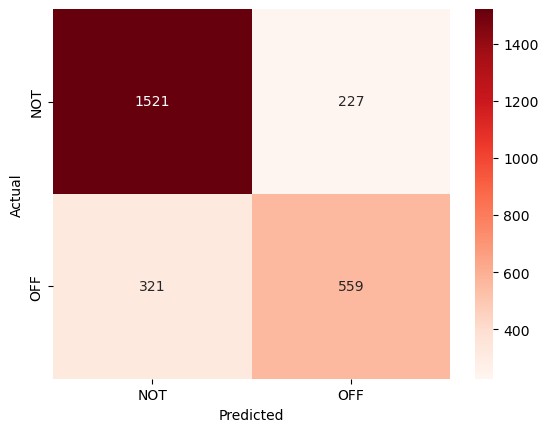

In [32]:
# Plot the confusion matrix of the hacked model
confusion_matrix = pd.crosstab(test_df['labels'], test_df['predicted'], rownames=['Actual'], colnames=['Predicted']) 
sn.heatmap(confusion_matrix, annot=True, cmap='Reds', fmt='g')
plt.show()